In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange, tqdm

In [2]:
path_datasets = Path('./datasets')

ls = [f for f in path_datasets.glob('*') if f.is_file()]
ls

[PosixPath('datasets/test.csv'),
 PosixPath('datasets/train.csv'),
 PosixPath('datasets/sample_submission.csv')]

In [3]:
_data = np.loadtxt(ls[1], skiprows=1, delimiter=',')

X = _data[:, 1:]
Y = _data[:,0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
X_test, X_eval, Y_test, Y_eval = train_test_split(X_test, Y_test, test_size=0.5)

print(f'{X_train.shape=}')
print(f'{X_test.shape=}')
print(f'{X_eval.shape=}')
print()

print(f'{Y_train.shape=}')
print(f'{Y_test.shape=}')
print(f'{Y_eval.shape=}')

X_train.shape=(29400, 784)
X_test.shape=(6300, 784)
X_eval.shape=(6300, 784)

Y_train.shape=(29400,)
Y_test.shape=(6300,)
Y_eval.shape=(6300,)


## Pytorch

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

# # check if torch supports mac gpu
# if torch.backends.mps.is_available() and\
#     torch.backends.mps.is_built():
#     device = torch.device("mps")
    
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

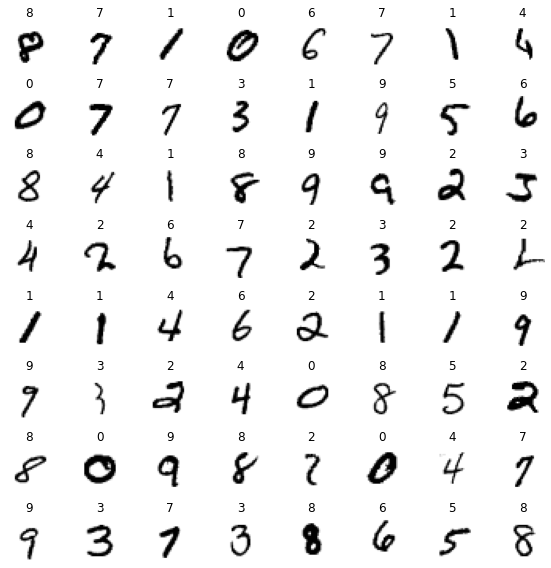

In [5]:
G = 8

figure = plt.figure(figsize=(G, G))

for i in np.arange(G*G):
    sample_idx = np.random.choice(np.arange(len(X_train)), G*G, replace=False)
    img, label = X_train[sample_idx[i]], Y_train[sample_idx[i]]
    figure.add_subplot(G, G, i + 1)
    plt.title(int(label))
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray_r")
plt.tight_layout()
plt.show()

In [6]:
class TinyModel(nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 10 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))

# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))


  0%|          | 0/1000 [00:00<?, ?it/s]

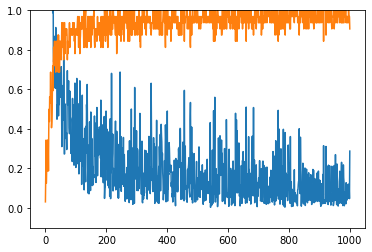

In [7]:
model = TinyModel()
model.to(device)

BATCH_SIZE = 32
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
losses, accuracies = [], []

for i in (t := trange(1000)):
    model.train()
    samp = np.random.choice(range(X_train.shape[0]), size = BATCH_SIZE, replace=False)
    X = torch.tensor(X_train[samp].reshape((len(samp), 1, 28, 28)), dtype=torch.float32)
    Y = torch.tensor(Y_train[samp], dtype=torch.int)
    
    X = X.to(device)
    Y = Y.to(device)
    optim.zero_grad() #zero_grad
    out = model(X)
    loss = F.nll_loss(out, Y)
    
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    
    t.set_description(f"loss {loss:.2f}, accuracy {accuracy:.2f}")

# print(f"{losses=}, {accuracies=}")    
plt.ylim(-0.1,1)
plt.plot(losses)
plt.plot(accuracies)
plt.show()

In [ ]:
# evaluation


model.to('cpu')

out = model(torch.tensor(X_train.reshape((-1, 1, 28, 28)), dtype=torch.float32))
Y_train_preds = torch.argmax(out, dim=1)
(Y_train == Y_train_preds).mean()